In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import torchaudio
import torch
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# to play the audio files
from IPython.display import Audio
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification


In [3]:

# Crema_path = Root_dir + "/Crema/"
# Ravdess_path = Root_dir + "/Ravdess/audio_speech_actors_01-24/"
# Savee_path = Root_dir + "/Savee/"
# Tess_path = Root_dir + "/Tess/"
# print(Crema_path ,"\n")
# print(Ravdess_path,"\n")
# print(Savee_path,"\n")
# print(Tess_path,"\n")

# Download latest version
import kagglehub
path = kagglehub.dataset_download("dmitrybabko/speech-emotion-recognition-en")

print("Path to dataset files:", path)



paths = []
labels = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

print('Dataset is Loaded')

100%|██████████| 987M/987M [00:44<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1
Dataset is Loaded
Dataset is Loaded


In [4]:
root_dir = path

Crema_path = root_dir + "/Crema/"
Ravdess_path = root_dir + "/Ravdess/audio_speech_actors_01-24/"
Savee_path = root_dir + "/Savee/"
Tess_path = root_dir + "/Tess/"
print(Tess_path,"\n")
print(Savee_path,"\n")
print(Ravdess_path,"\n")
print(Crema_path,"\n")

/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/ 

/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/ 

/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/ 

/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/ 



In [5]:
Crema_dir_list = os.listdir(Crema_path)
Ravdess_dir_list = os.listdir(Ravdess_path)
Savee_dir_list = os.listdir(Savee_path)
Tess_dir_list = os.listdir(Tess_path)

In [6]:
Ex_Crema_dir_list = Crema_dir_list[:15]
Ex_Crema_dir_list

['1035_TIE_HAP_XX.wav',
 '1067_ITH_HAP_XX.wav',
 '1071_IEO_NEU_XX.wav',
 '1090_MTI_DIS_XX.wav',
 '1068_TAI_FEA_XX.wav',
 '1068_IEO_SAD_LO.wav',
 '1071_IWL_ANG_XX.wav',
 '1086_ITS_DIS_XX.wav',
 '1034_DFA_SAD_XX.wav',
 '1005_WSI_NEU_XX.wav',
 '1088_ITH_HAP_XX.wav',
 '1074_IOM_ANG_XX.wav',
 '1072_DFA_FEA_XX.wav',
 '1058_WSI_NEU_XX.wav',
 '1076_IEO_HAP_LO.wav']

In [7]:
emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # storing file paths
    paths_crema.append(Crema_path + it)
    # storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')

# dataframe for emotion of files
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

# dataframe for path of files.
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(Crema_df.shape)
Crema_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})


(7442, 2)


,Emotions,Path
0,happy,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1035_TIE_HAP_XX.wav
1,happy,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1067_ITH_HAP_XX.wav
2,neutral,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1071_IEO_NEU_XX.wav
3,disgust,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1090_MTI_DIS_XX.wav
4,fear,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1068_TAI_FEA_XX.wav


In [8]:
[Crema_df["Emotions"].unique().tolist() for i in Crema_df.columns]

[['happy', 'neutral', 'disgust', 'fear', 'sad', 'angry'],
 ['happy', 'neutral', 'disgust', 'fear', 'sad', 'angry']]

In [9]:
font1 = {'family':'Times New Roman','color':'blue','size':30}
font2 = {'family':'Times New Roman','color':'blue','size':20}
font3 = {'family':'Times New Roman','color':'blue','size':10}

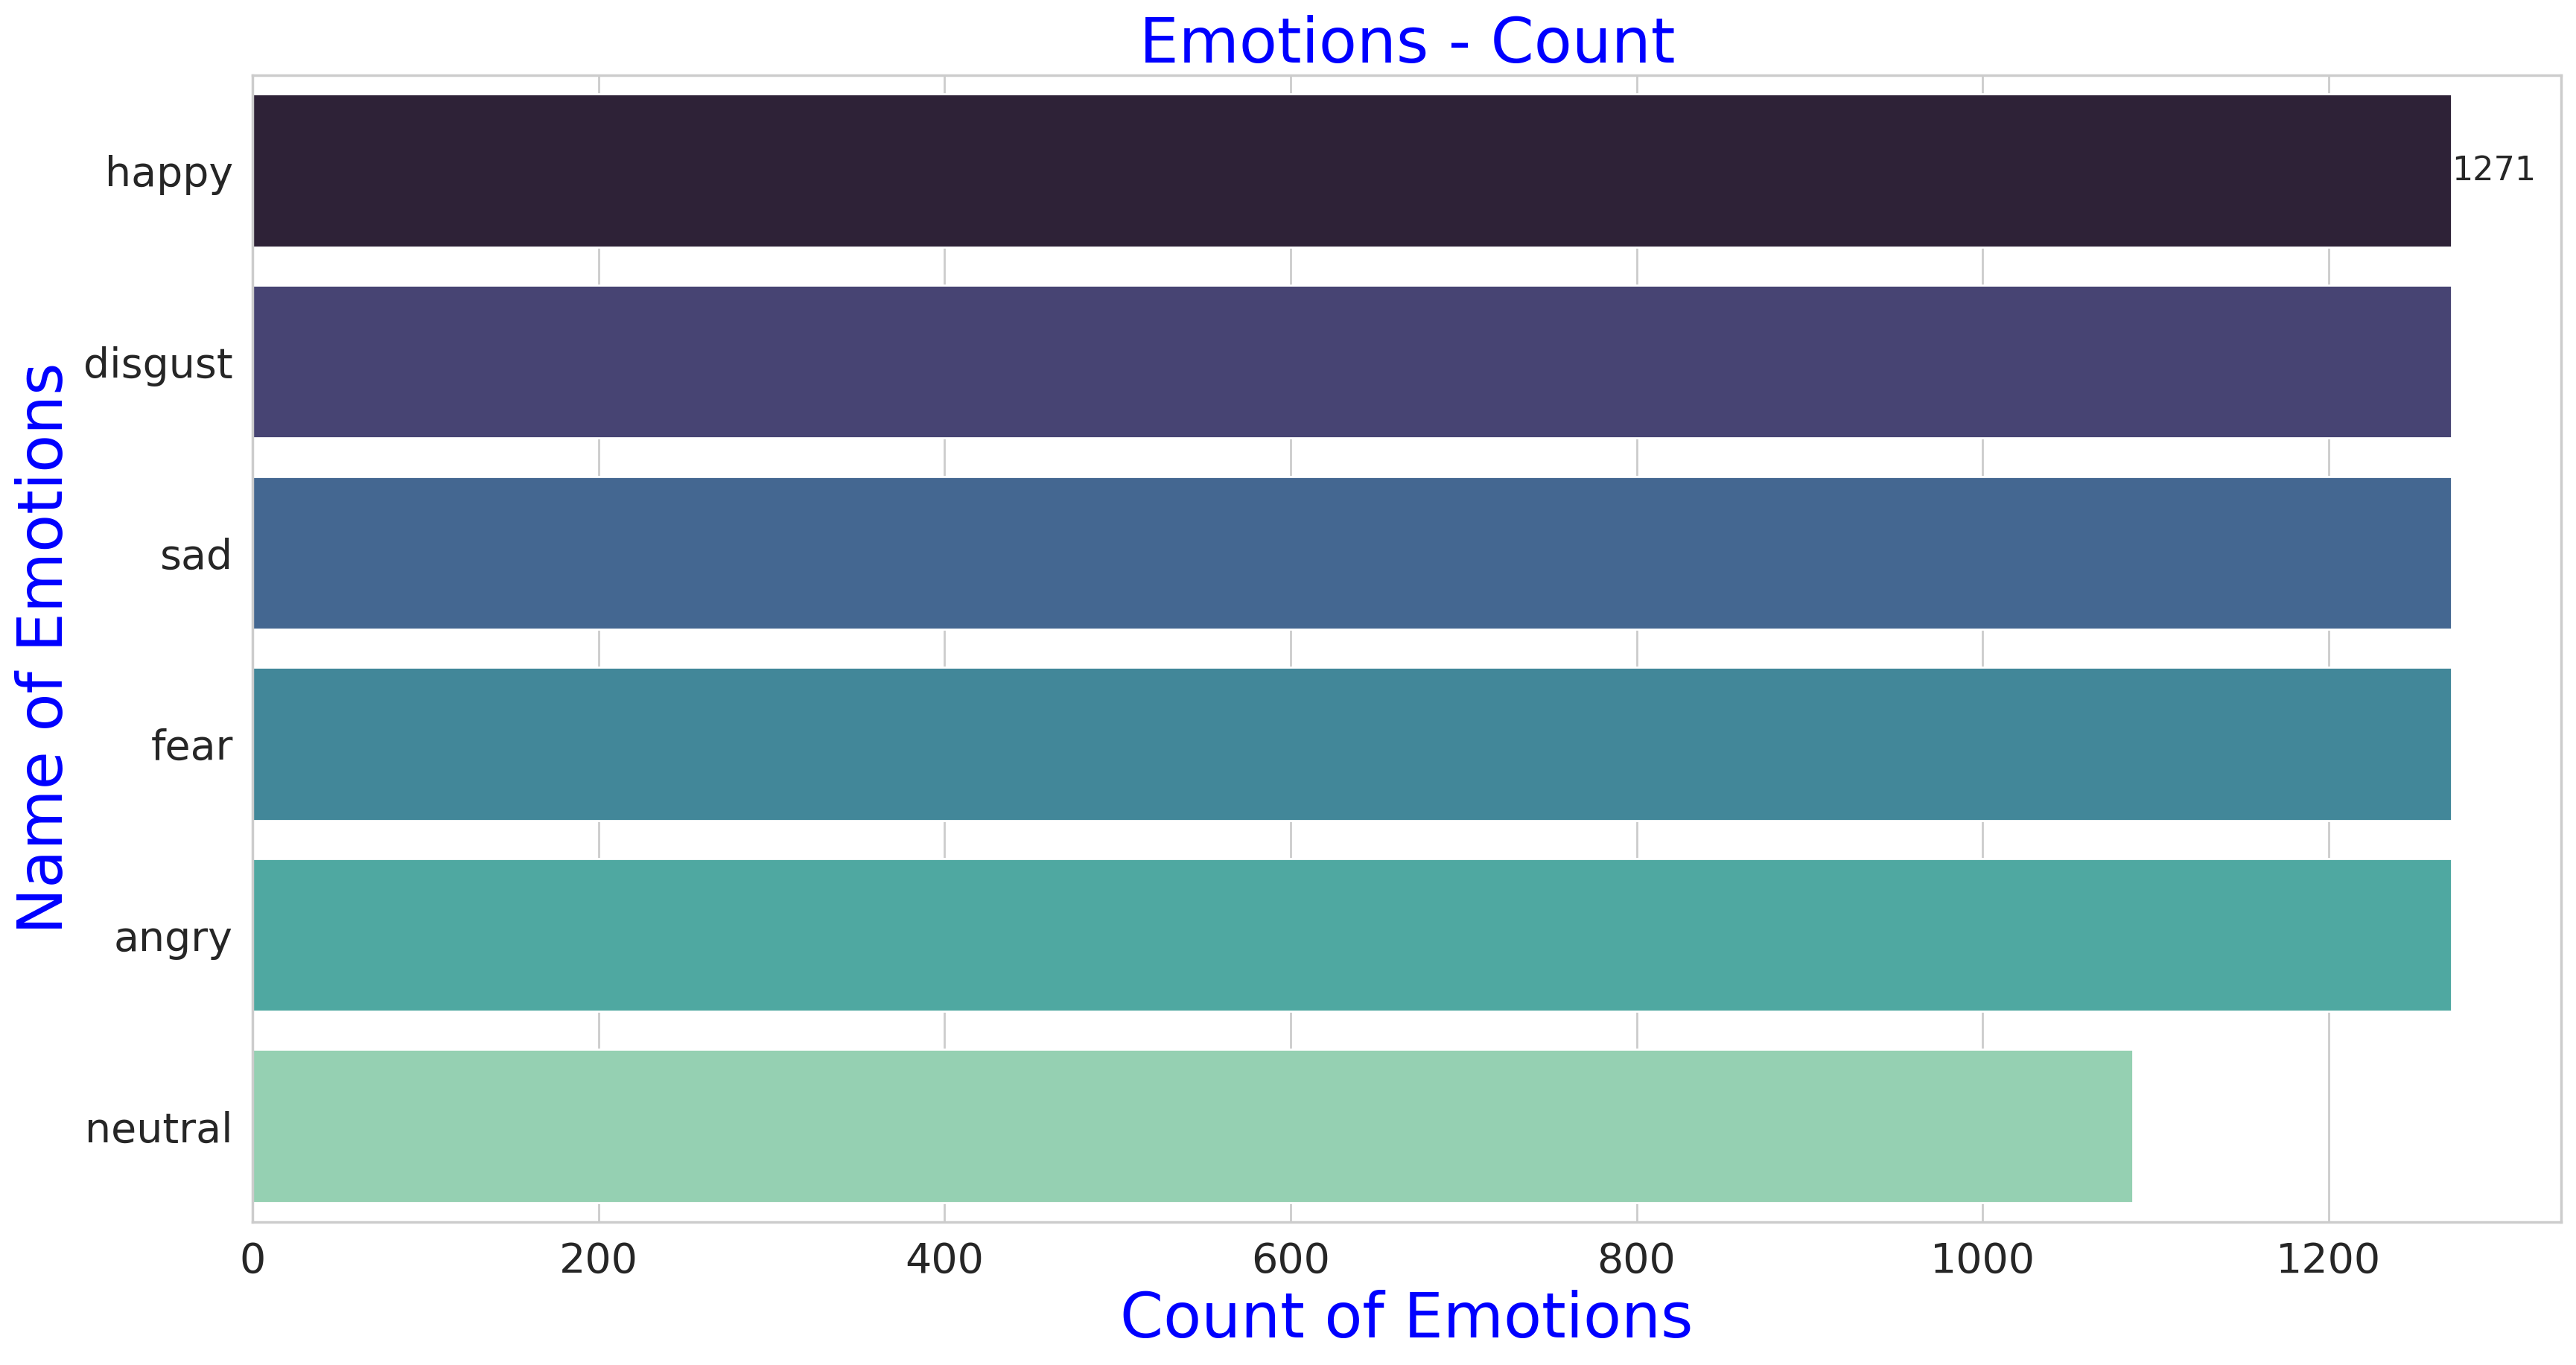

In [10]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Crema_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [11]:
Ex_Ravdess_dir_list = Ravdess_dir_list[:15]
Ex_Ravdess_dir_list


['Actor_17',
 'Actor_21',
 'Actor_18',
 'Actor_02',
 'Actor_07',
 'Actor_16',
 'Actor_13',
 'Actor_09',
 'Actor_24',
 'Actor_19',
 'Actor_05',
 'Actor_01',
 'Actor_04',
 'Actor_11',
 'Actor_20']

In [12]:
emotions_ravdess = []
path_ravdess = []

for it in Ravdess_dir_list:
    # There are 20 actors
    actor = os.listdir(Ravdess_path + it)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        emotions_ravdess.append(int(part[2]))
        path_ravdess.append(Ravdess_path + it + '/' + file)


emotion_ravdess_df = pd.DataFrame(emotions_ravdess, columns=['Emotions'])

path_ravdess_df = pd.DataFrame(path_ravdess, columns=['Path'])
Ravdess_df = pd.concat([emotion_ravdess_df, path_ravdess_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm',
                             3:'happy', 4:'sad', 5:'angry',
                             6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

,Emotions,Path
0,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-05-02-02-01-17.wav
1,fear,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-06-01-02-01-17.wav
2,calm,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-02-02-02-01-17.wav
3,disgust,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-07-01-01-01-17.wav
4,fear,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Ravdess/audio_speech_actors_01-24/Actor_17/03-01-06-01-01-01-17.wav


In [13]:
[Ravdess_df["Emotions"].unique().tolist() for i in Ravdess_df.columns]

[['angry', 'fear', 'calm', 'disgust', 'happy', 'surprise', 'sad', 'neutral'],
 ['angry', 'fear', 'calm', 'disgust', 'happy', 'surprise', 'sad', 'neutral']]

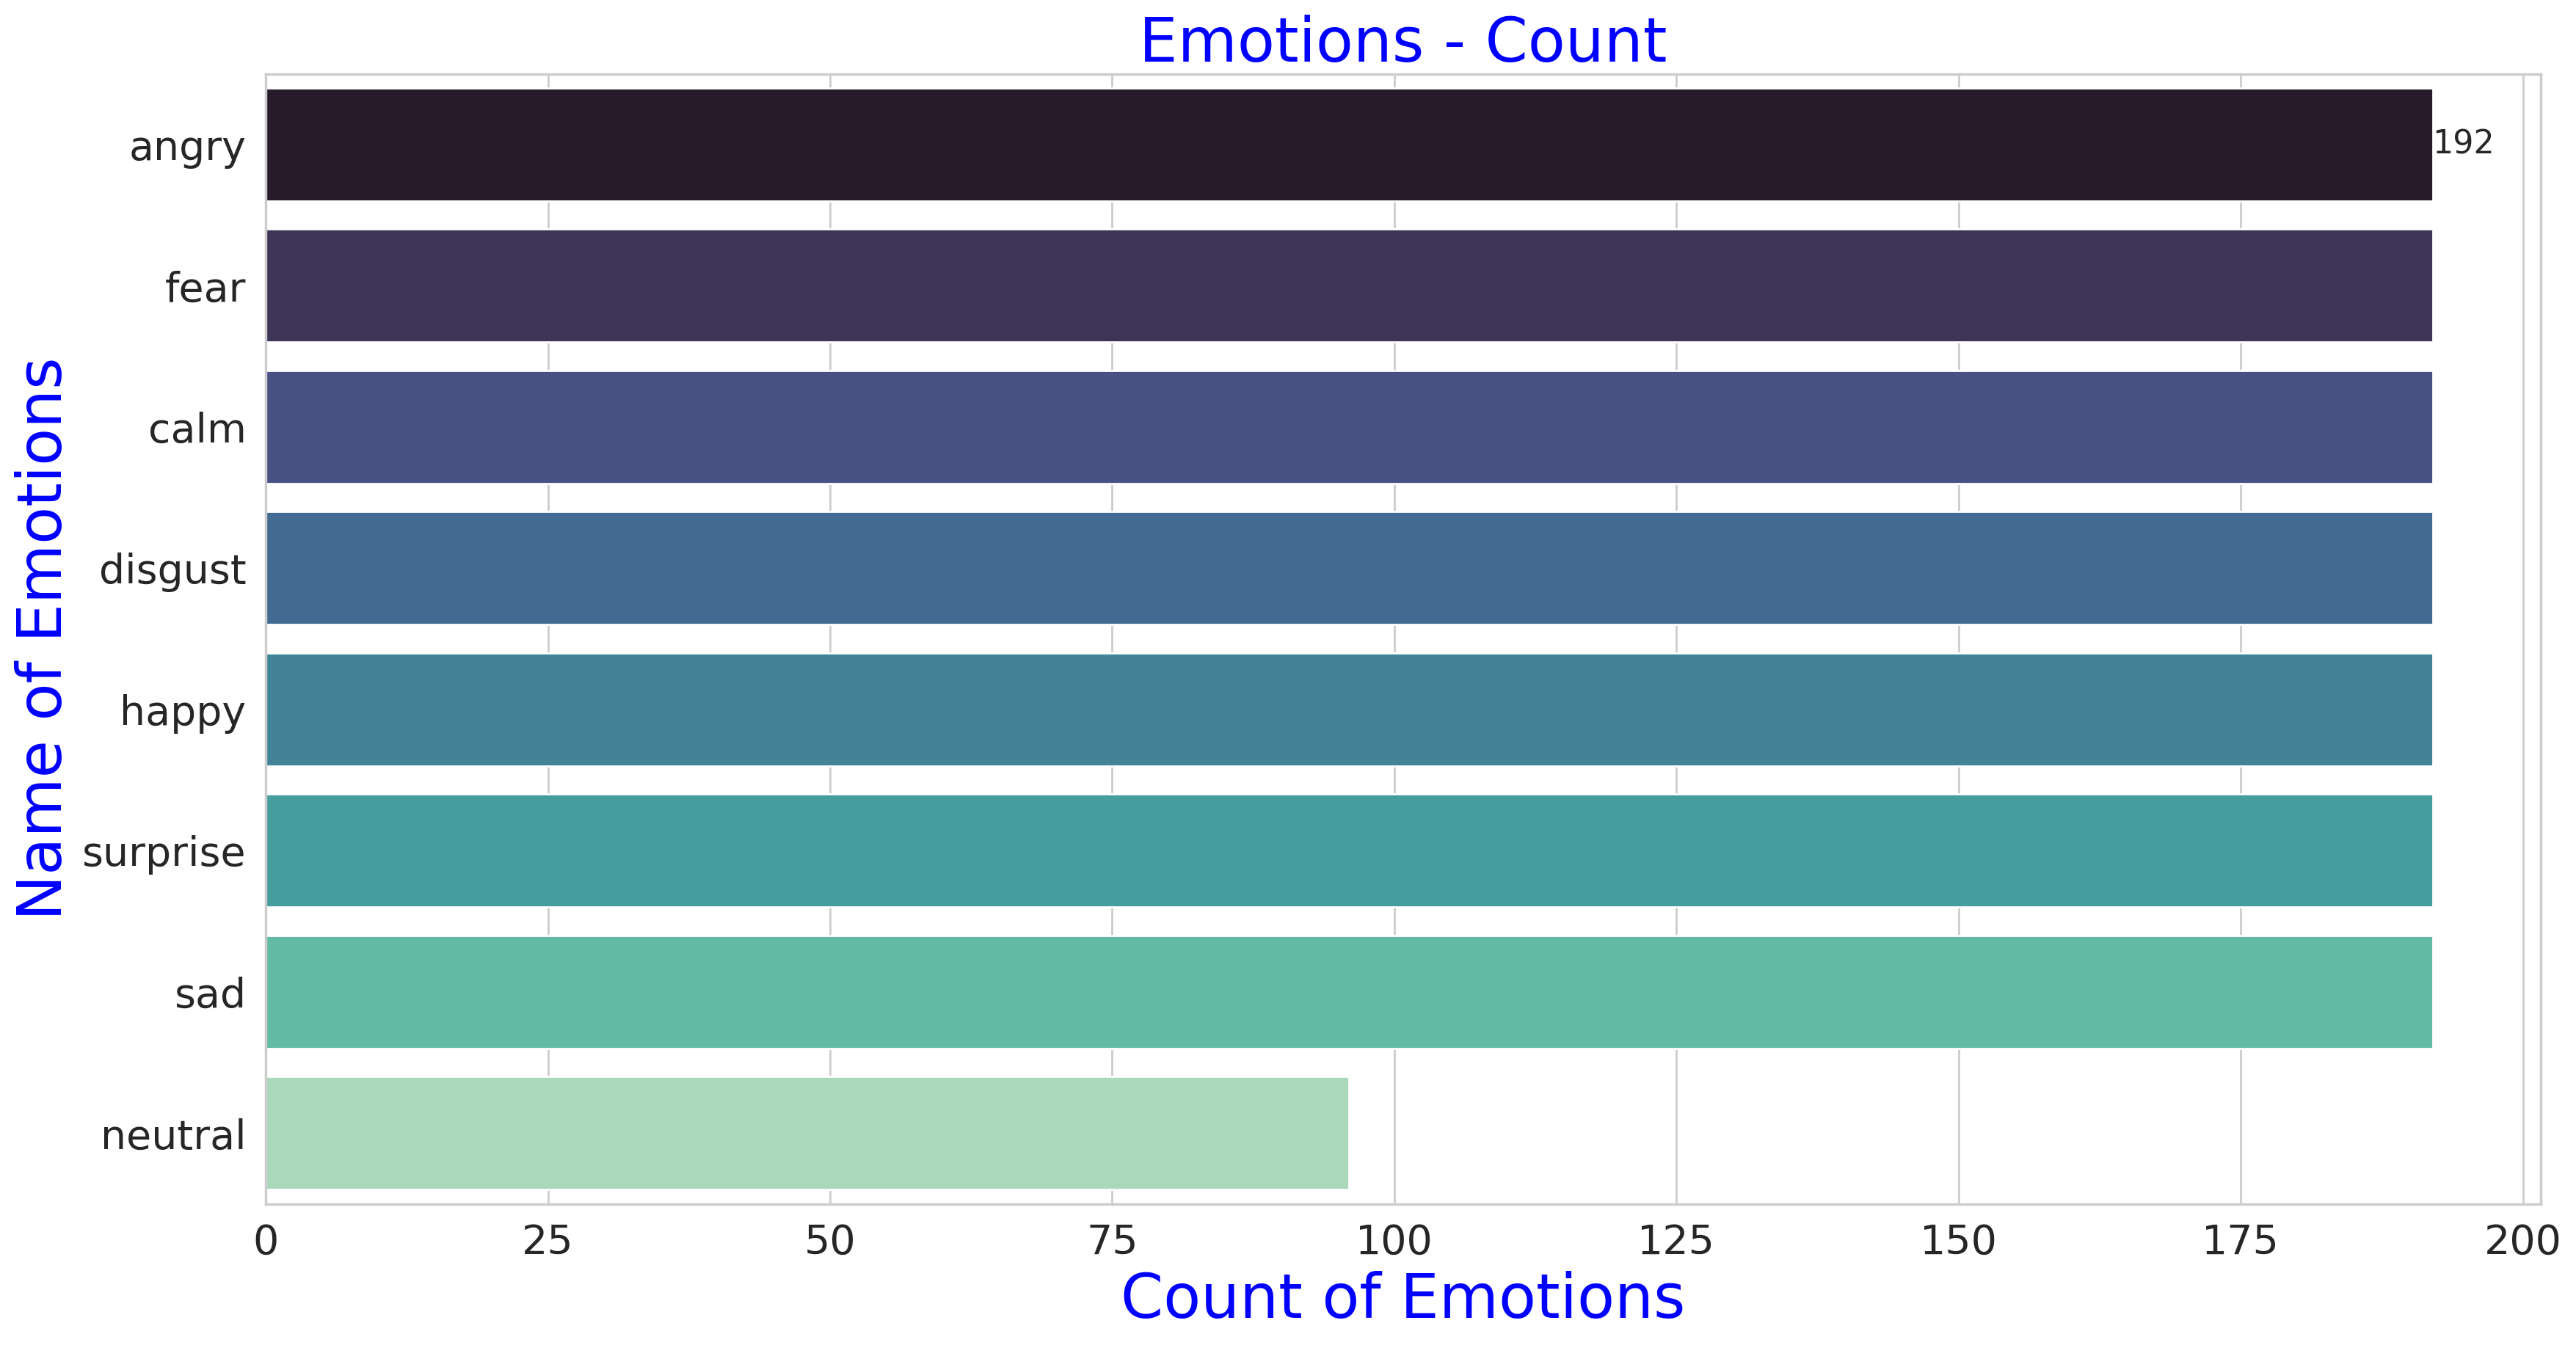

In [14]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Ravdess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [15]:
Ex_Savee_dir_list = Savee_dir_list[:15]
Ex_Savee_dir_list

['JK_n28.wav',
 'KL_f02.wav',
 'JE_a03.wav',
 'KL_su14.wav',
 'KL_n26.wav',
 'JE_f01.wav',
 'JK_f14.wav',
 'DC_n06.wav',
 'JE_h05.wav',
 'JE_sa03.wav',
 'DC_su03.wav',
 'JK_h10.wav',
 'JE_sa08.wav',
 'DC_n22.wav',
 'DC_a09.wav']

In [16]:
emotions_savee = []
path_savee = []

for it in Savee_dir_list:
    path_savee.append(Savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('angry')
    elif part == 'd':
        emotions_savee.append('disgust')
    elif part == 'f':
        emotions_savee.append('fear')
    elif part == 'h':
        emotions_savee.append('happiness')
    elif part == 'n':
        emotions_savee.append('neutral')
    elif part == 'sa':
        emotions_savee.append('sadness')
    elif part == 'su':
        emotions_savee.append('surprise')

    else:
        emotions_savee.append('Unknown')

# dataframe for emotion of files
emotion_savee_df = pd.DataFrame(emotions_savee, columns=['Emotions'])

# dataframe for path of files.
path_savee_df = pd.DataFrame(path_savee, columns=['Path'])
Savee_df = pd.concat([emotion_savee_df, path_savee_df], axis=1)
Savee_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

,Emotions,Path
0,neutral,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/JK_n28.wav
1,fear,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/KL_f02.wav
2,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/JE_a03.wav
3,surprise,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/KL_su14.wav
4,neutral,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Savee/KL_n26.wav


In [17]:
[Savee_df["Emotions"].unique().tolist() for i in Savee_df.columns]

[['neutral', 'fear', 'angry', 'surprise', 'happiness', 'sadness', 'disgust'],
 ['neutral', 'fear', 'angry', 'surprise', 'happiness', 'sadness', 'disgust']]

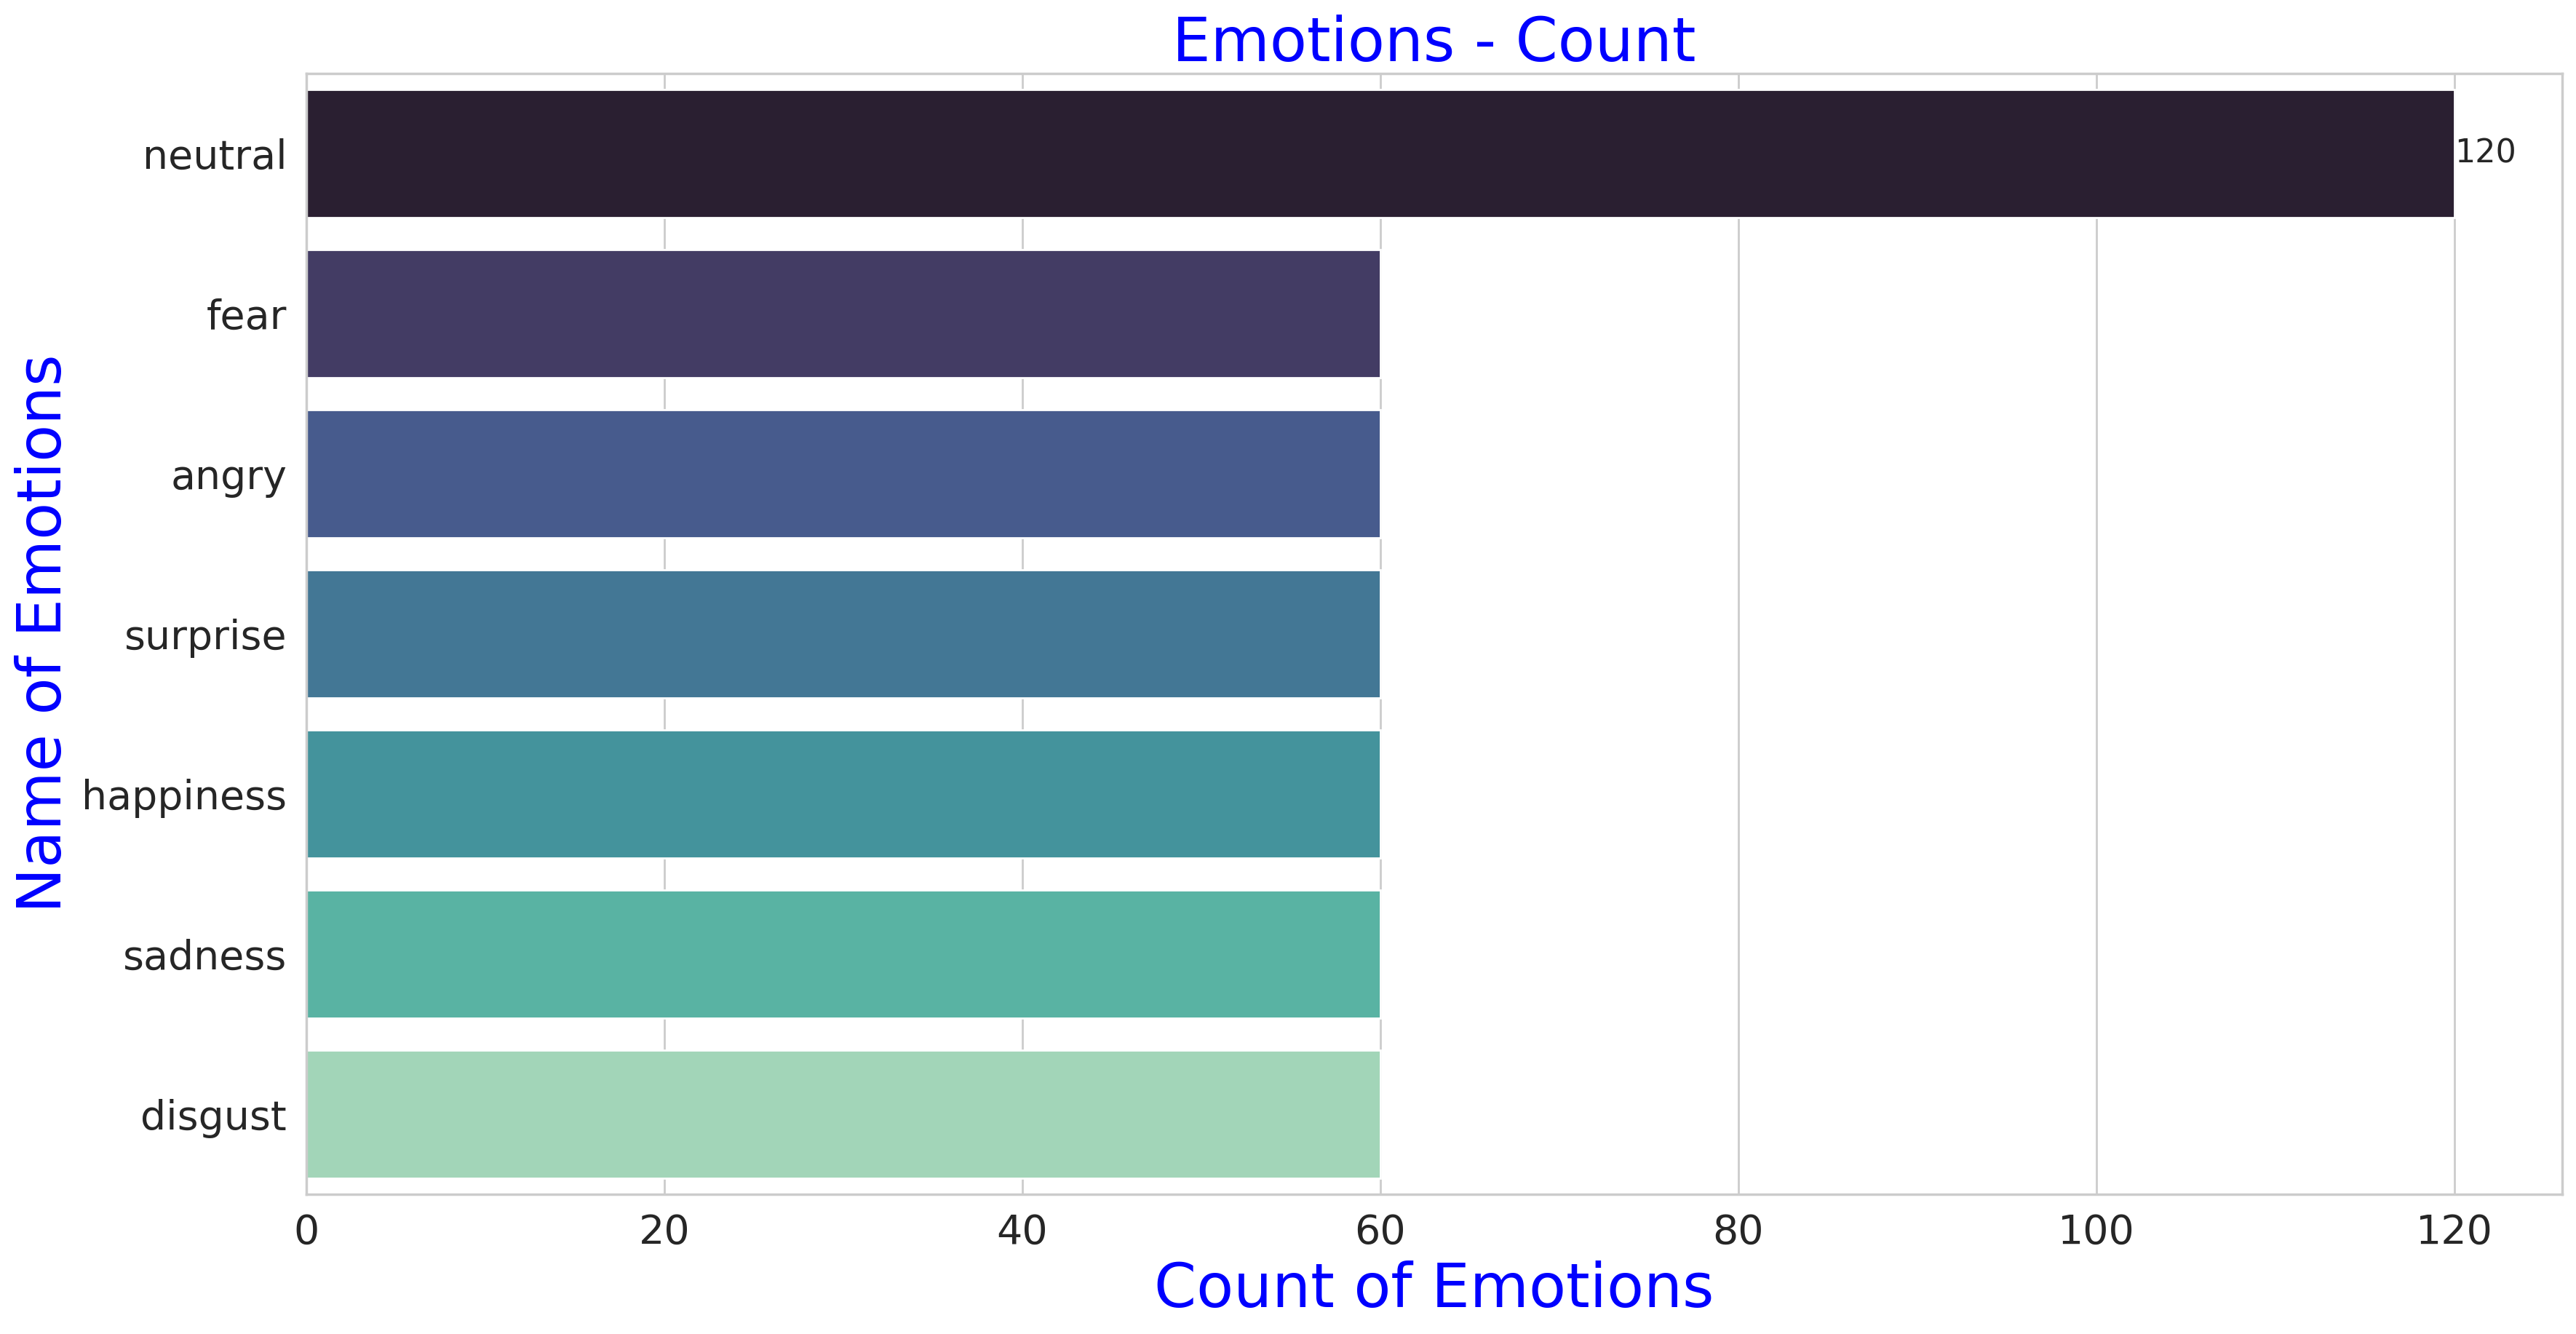

In [18]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Savee_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [19]:
Ex_Tess_dir_list = Tess_dir_list[:15]
Ex_Tess_dir_list

['YAF_angry',
 'OAF_Pleasant_surprise',
 'OAF_neutral',
 'OAF_angry',
 'YAF_pleasant_surprised',
 'YAF_neutral',
 'YAF_happy',
 'OAF_happy',
 'YAF_fear',
 'YAF_disgust',
 'OAF_Fear',
 'YAF_sad',
 'OAF_disgust',
 'OAF_Sad']

In [20]:
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)



# dataframe for emotion of files
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])

# dataframe for path of files.
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)
Tess_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

,Emotions,Path
0,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/YAF_angry/YAF_burn_angry.wav
1,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/YAF_angry/YAF_yearn_angry.wav
2,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/YAF_angry/YAF_mouse_angry.wav
3,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/YAF_angry/YAF_shawl_angry.wav
4,angry,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Tess/YAF_angry/YAF_gap_angry.wav


In [21]:
[Tess_df["Emotions"].unique().tolist() for i in Tess_df.columns]

[['angry', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'sad'],
 ['angry', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'sad']]

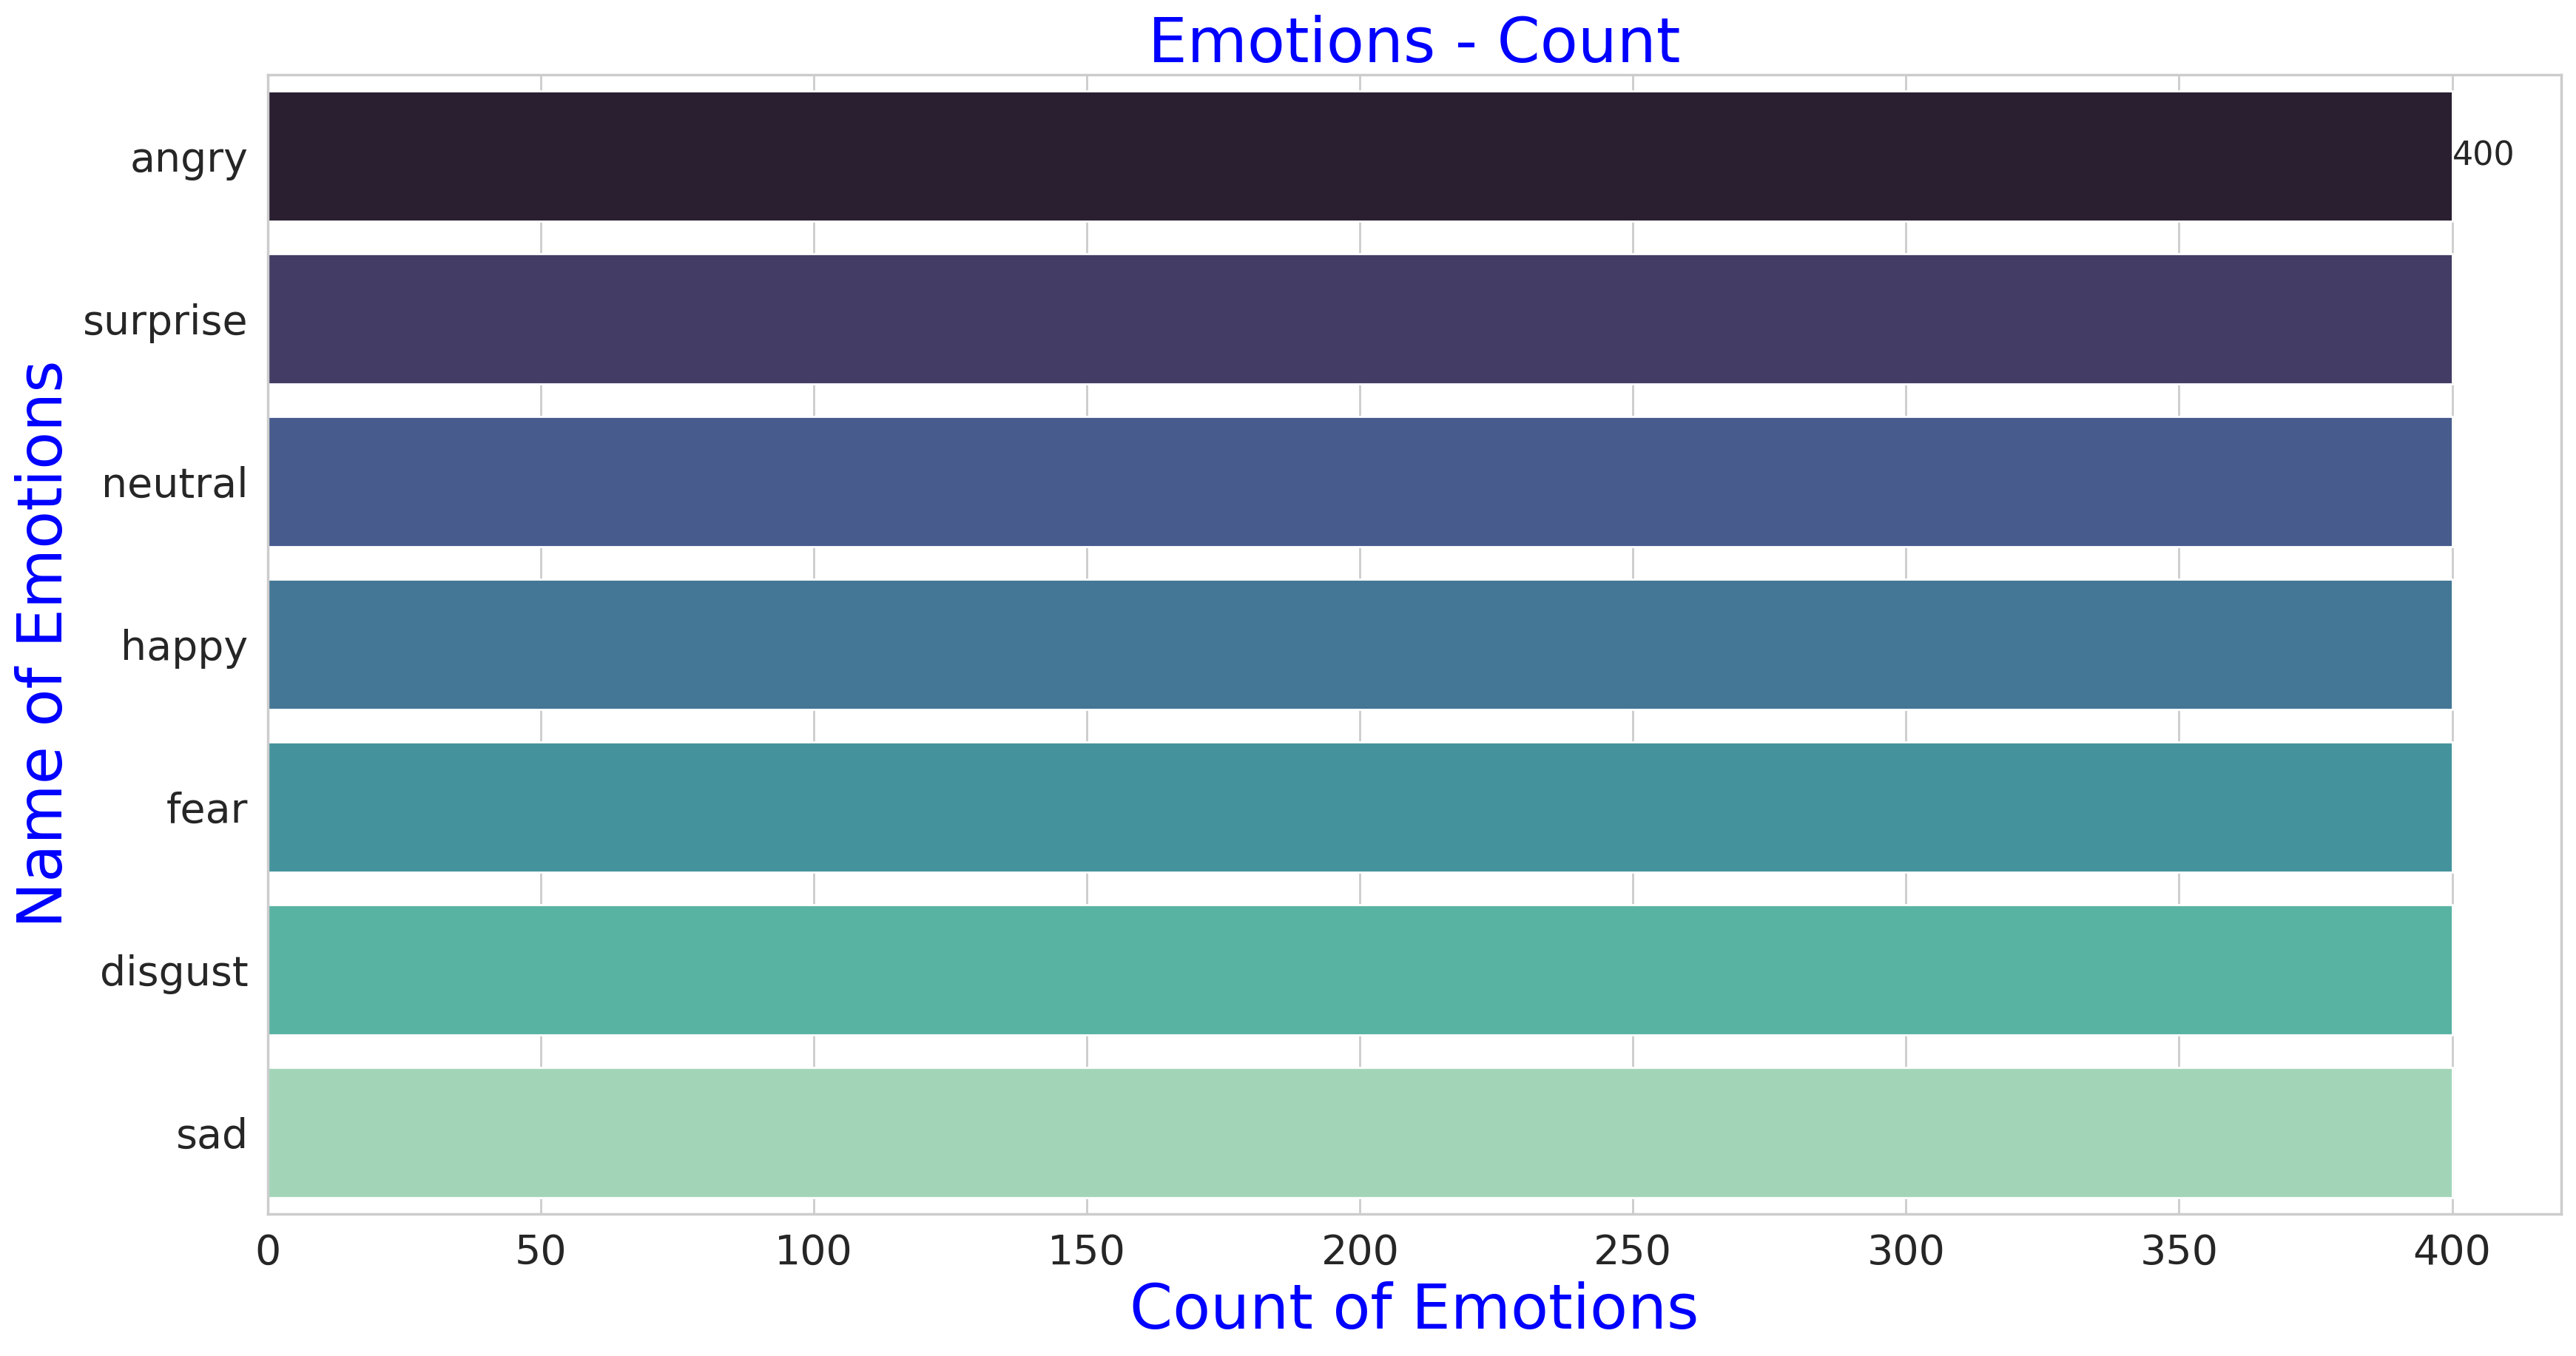

In [22]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Tess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [23]:
Sum_df = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis = 0)
Sum_df.to_csv("Sum_df.csv",index=False)
Sum_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})

,Emotions,Path
0,happy,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1035_TIE_HAP_XX.wav
1,happy,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1067_ITH_HAP_XX.wav
2,neutral,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1071_IEO_NEU_XX.wav
3,disgust,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1090_MTI_DIS_XX.wav
4,fear,/root/.cache/kagglehub/datasets/dmitrybabko/speech-emotion-recognition-en/versions/1/Crema/1068_TAI_FEA_XX.wav


In [24]:
[Sum_df["Emotions"].unique().tolist() for i in Sum_df.columns]

[['happy',
  'neutral',
  'disgust',
  'fear',
  'sad',
  'angry',
  'calm',
  'surprise',
  'happiness',
  'sadness'],
 ['happy',
  'neutral',
  'disgust',
  'fear',
  'sad',
  'angry',
  'calm',
  'surprise',
  'happiness',
  'sadness']]

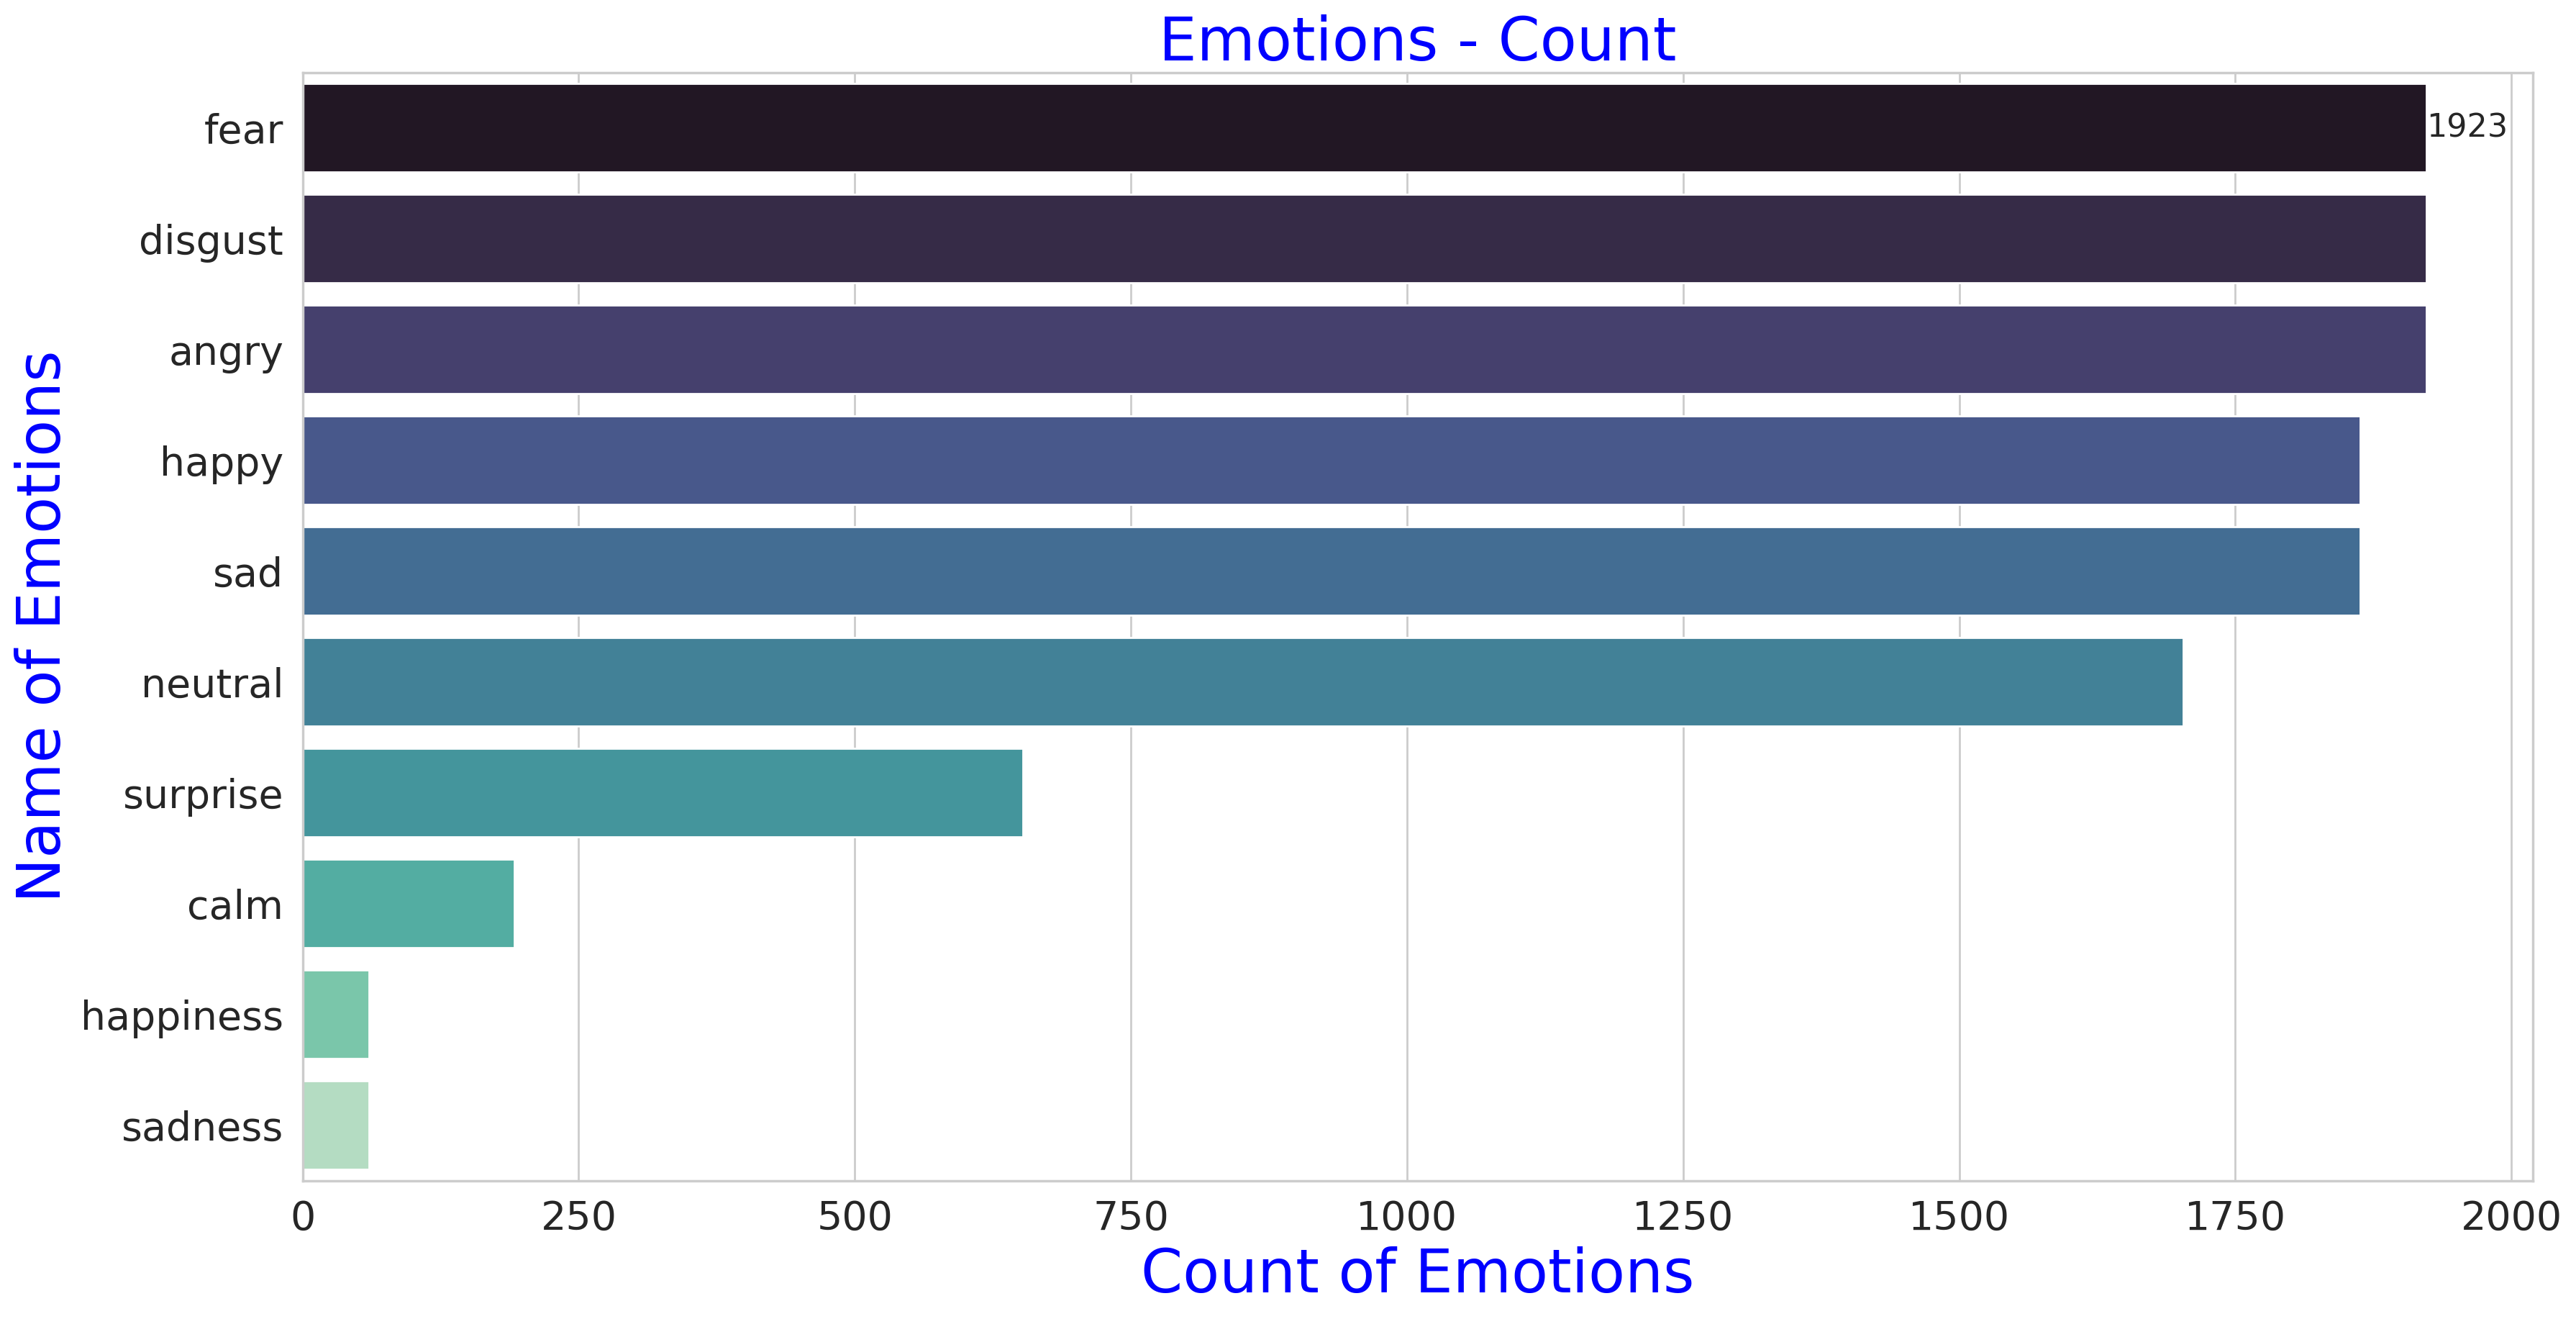

In [25]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [26]:
Sum_df_rep = Sum_df
Sum_df_rep['Emotions'].replace('happiness', 'happy', inplace=True)
Sum_df_rep['Emotions'].replace('sadness', 'sad', inplace=True)
Sum_df_rep['Emotions'].replace('calm', 'neutral', inplace=True)

In [27]:
[Sum_df_rep["Emotions"].unique().tolist() for i in Sum_df_rep.columns]

[['happy', 'neutral', 'disgust', 'fear', 'sad', 'angry', 'surprise'],
 ['happy', 'neutral', 'disgust', 'fear', 'sad', 'angry', 'surprise']]

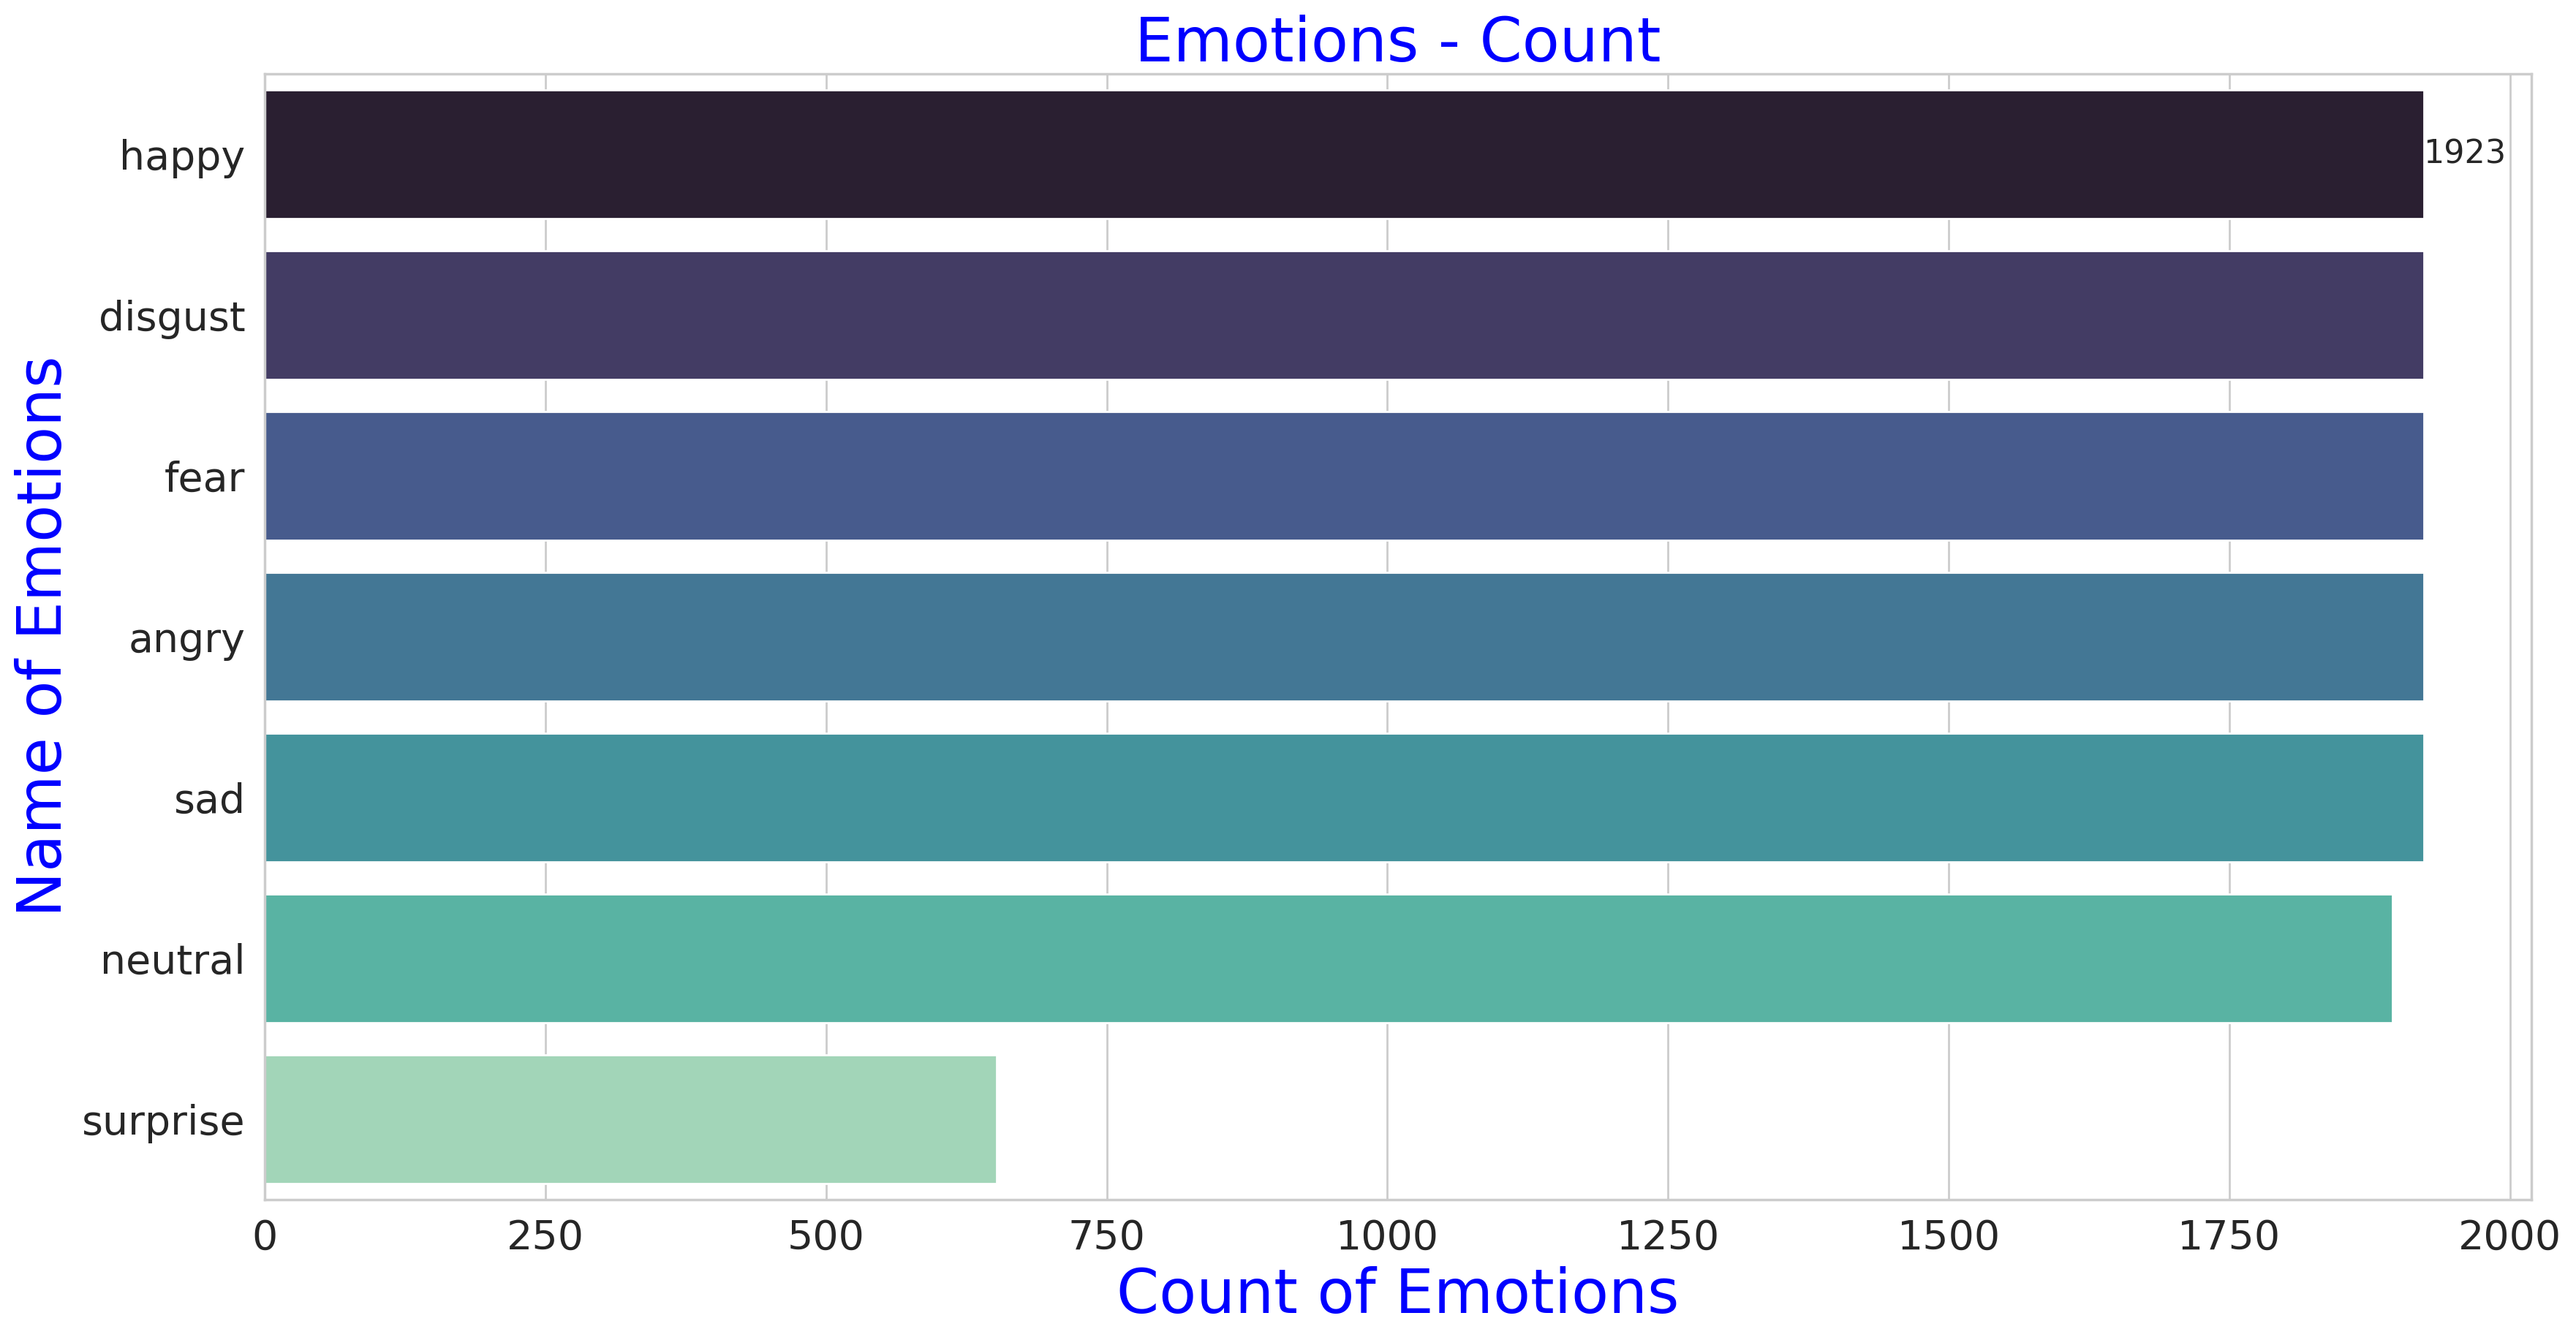

In [28]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df_rep['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [29]:
print(Sum_df)

     Emotions                                               Path
0       happy  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
1       happy  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
2     neutral  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
3     disgust  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
4        fear  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
...       ...                                                ...
2795      sad  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
2796      sad  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
2797      sad  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
2798      sad  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
2799      sad  /root/.cache/kagglehub/datasets/dmitrybabko/sp...

[12162 rows x 2 columns]


In [30]:
# label_map = {label: idx for idx, label in enumerate(Sum_df['Emotions'].unique())}
# inverse_label_map = {idx: label for label, idx in label_map.items()}
# Sum_df['Emotions'] = Sum_df['Emotions'].map(label_map)
# Sum_df.head(2)

In [31]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [32]:
filtered_rows = Sum_df[Sum_df['Emotions'].str.strip().str.lower() == 'angry']
print(filtered_rows)


    Emotions                                               Path
6      angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
11     angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
22     angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
23     angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
29     angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
..       ...                                                ...
795    angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
796    angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
797    angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
798    angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...
799    angry  /root/.cache/kagglehub/datasets/dmitrybabko/sp...

[1923 rows x 2 columns]


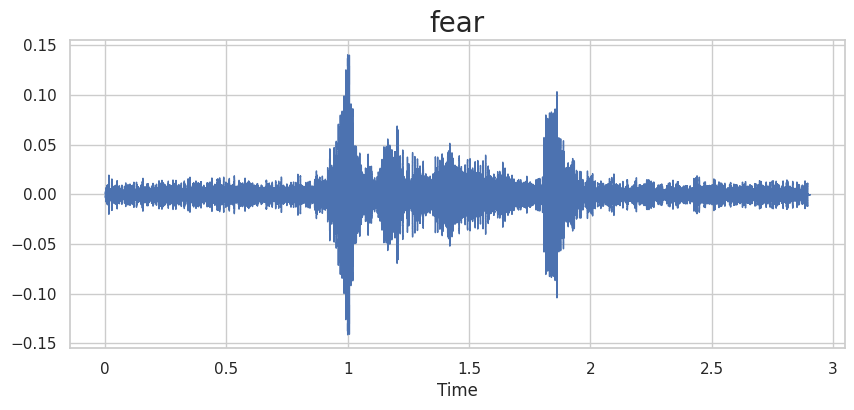

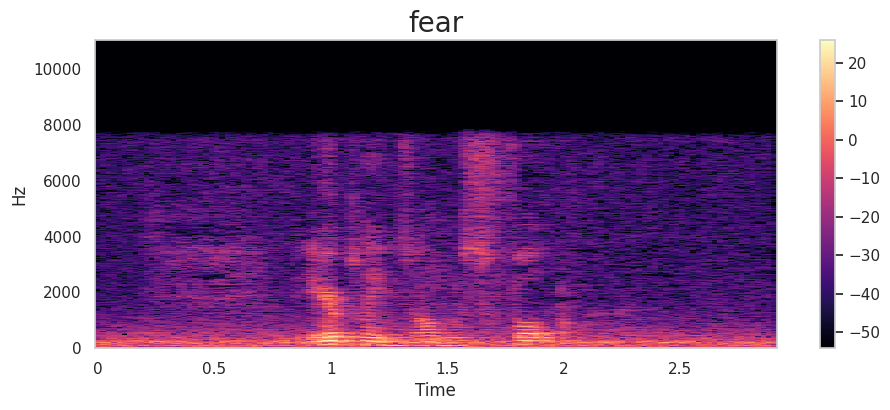

In [33]:
emotion = 'fear'
path = np.array(Sum_df['Path'][Sum_df['Emotions']== emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

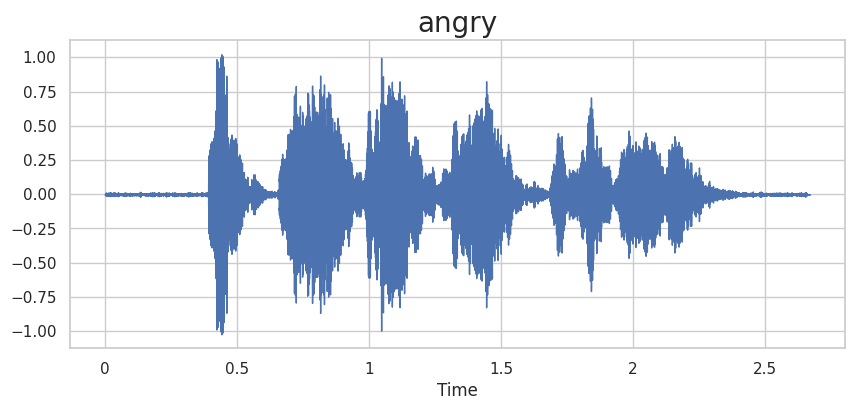

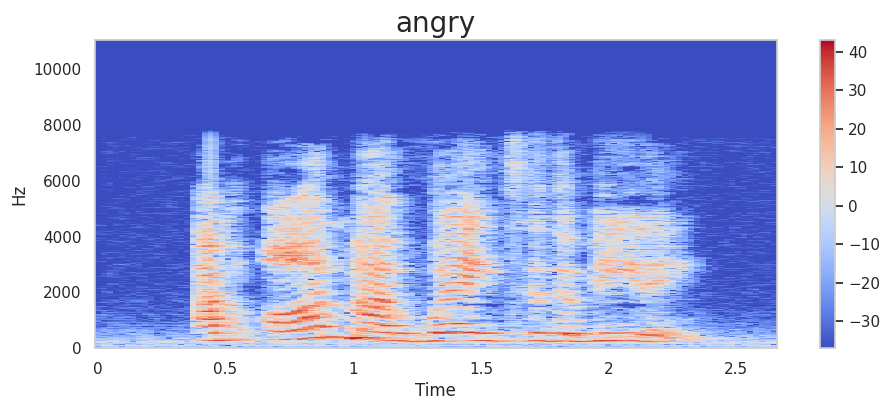

In [34]:
emotion = 'angry'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

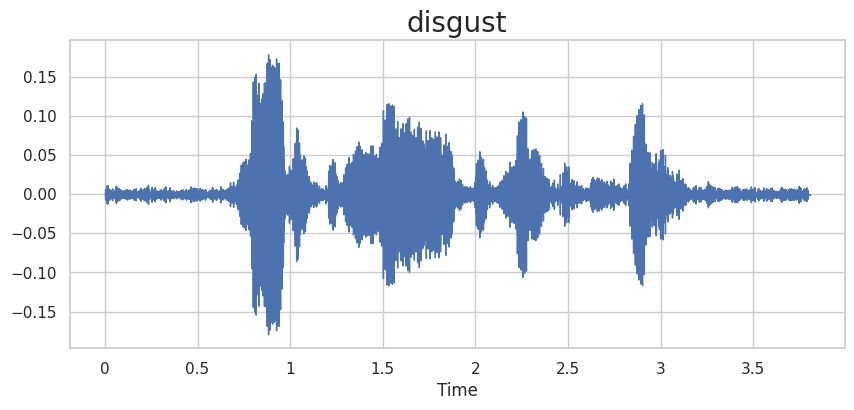

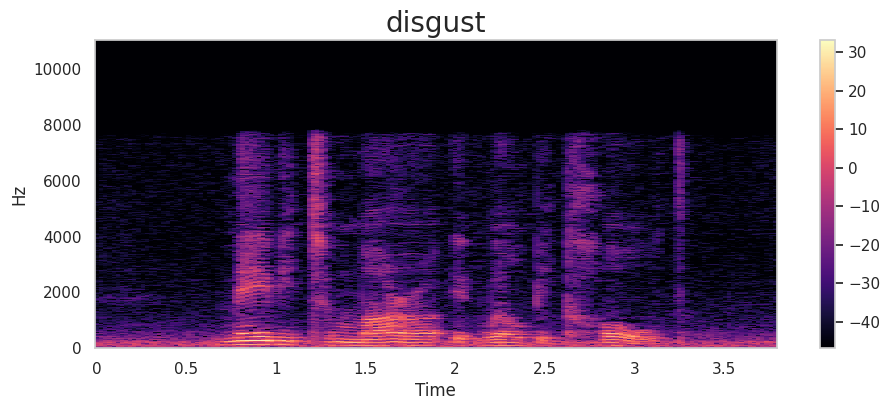

In [35]:
emotion = 'disgust'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

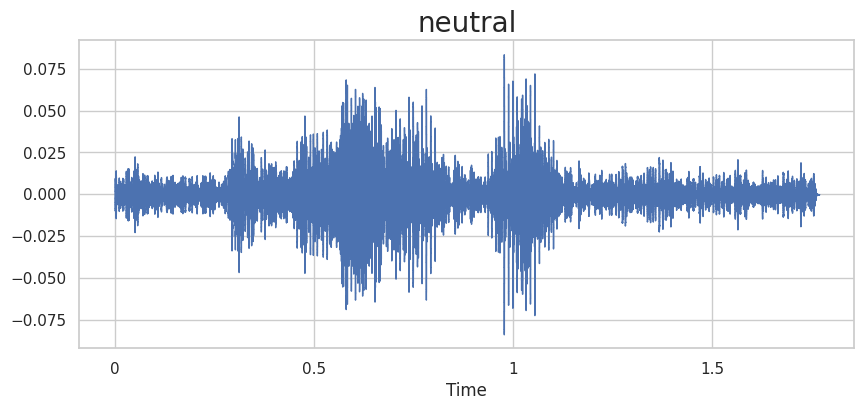

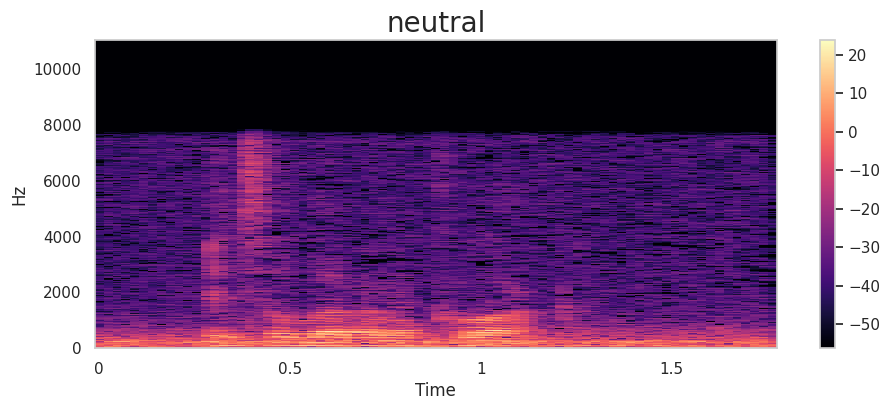

In [36]:
emotion = 'neutral'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

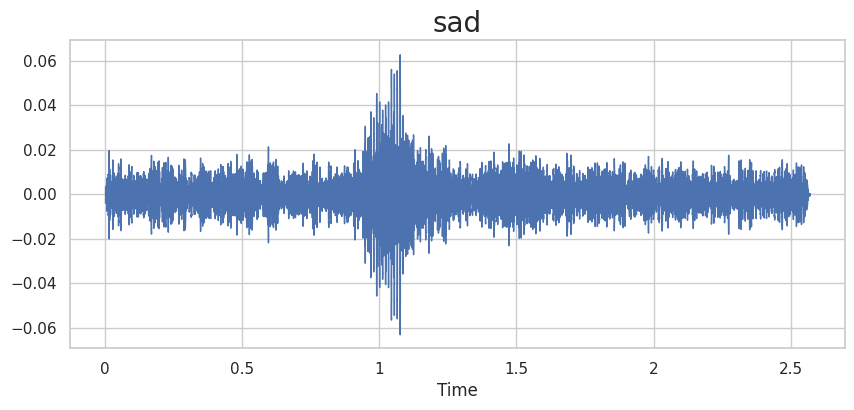

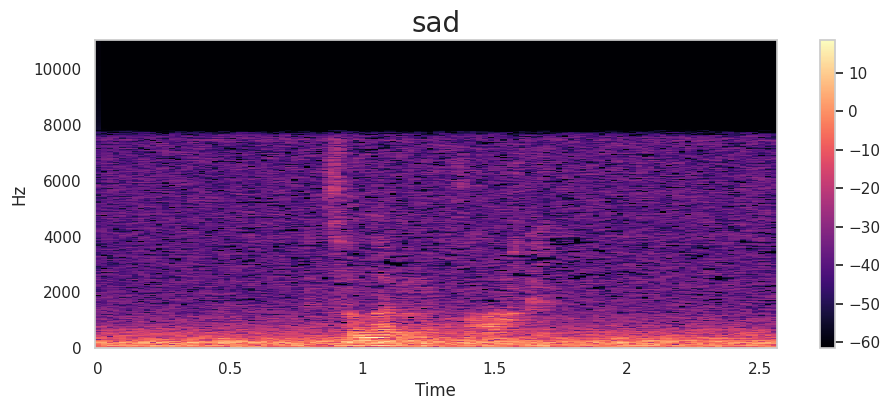

In [37]:
emotion = 'sad'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

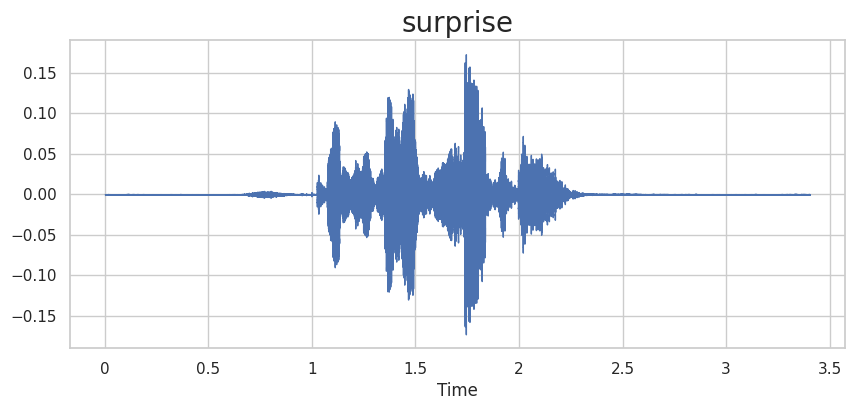

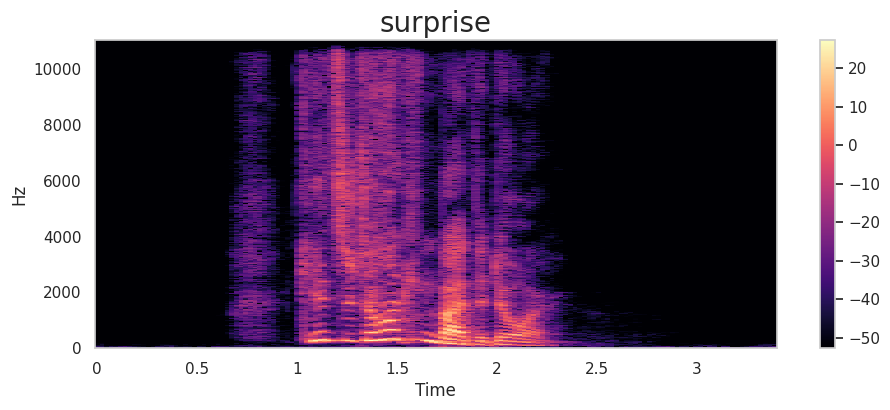

In [38]:
emotion = 'surprise'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

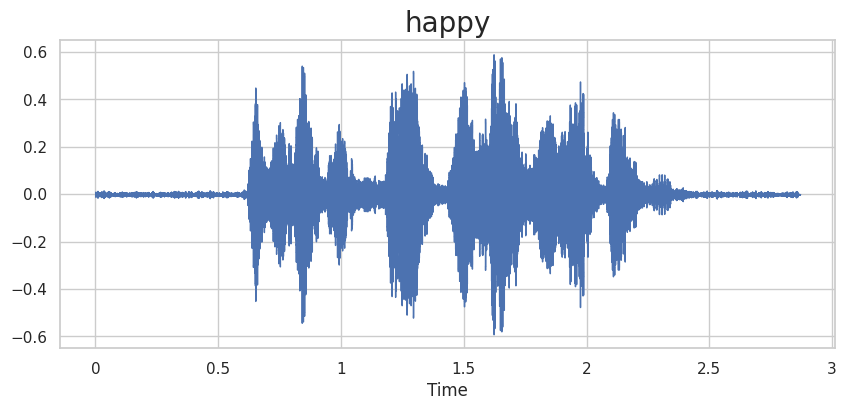

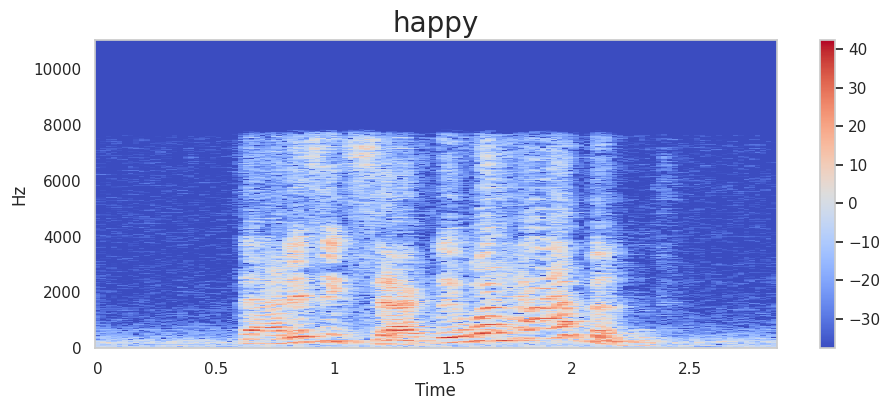

In [39]:
emotion = 'happy'
path = np.array(Sum_df['Path'][Sum_df['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [40]:
# convert labels to integers
label_map = {label: idx for idx, label in enumerate(Sum_df['Emotions'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
Sum_df['Emotions'] = Sum_df['Emotions'].map(label_map)
Sum_df.head(2)

,Emotions,Path
0,0,/root/.cache/kagglehub/datasets/dmitrybabko/sp...
1,0,/root/.cache/kagglehub/datasets/dmitrybabko/sp...


In [41]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['Path']
        label = self.df.iloc[idx]['Emotions']

        # load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)

        # pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [42]:
# split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(Sum_df, test_size=0.2, random_state=42)

In [43]:
# initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [45]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [46]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,  # Keep only the last 2 checkpoints
    learning_rate=1e-5,
    lr_scheduler_type='linear',
    warmup_ratio=0.1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to=["tensorboard"]
)


In [47]:
# create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids # original labels
    preds = np.argmax(pred.predictions, axis=1) # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [48]:
# initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.630500,1.556066,0.444307,0.449481,0.444307,0.396228
1000,1.160400,1.125217,0.651048,0.685396,0.651048,0.649056
1500,0.904800,0.942237,0.700781,0.720221,0.700781,0.698658
2000,0.744200,0.819984,0.739827,0.756060,0.739827,0.735830
2500,0.685300,0.747474,0.758734,0.764610,0.758734,0.755470
3000,0.606700,0.700014,0.773120,0.785984,0.773120,0.774831
3500,0.518400,0.688966,0.780107,0.785341,0.780107,0.777838
4000,0.478100,0.698350,0.776819,0.788793,0.776819,0.775178


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,1.630500,1.556066,0.444307,0.449481,0.444307,0.396228
1000,1.160400,1.125217,0.651048,0.685396,0.651048,0.649056
1500,0.904800,0.942237,0.700781,0.720221,0.700781,0.698658
2000,0.744200,0.819984,0.739827,0.756060,0.739827,0.735830
2500,0.685300,0.747474,0.758734,0.764610,0.758734,0.755470
3000,0.606700,0.700014,0.773120,0.785984,0.773120,0.774831
3500,0.518400,0.688966,0.780107,0.785341,0.780107,0.777838
4000,0.478100,0.698350,0.776819,0.788793,0.776819,0.775178
4500,0.407800,0.665449,0.791615,0.797887,0.791615,0.791275
5000,0.401200,0.675901,0.790793,0.800268,0.790793,0.789652


TrainOutput(global_step=6090, training_loss=0.7352484952052826, metrics={'train_runtime': 1892.1278, 'train_samples_per_second': 51.418, 'train_steps_per_second': 3.219, 'total_flos': 1.76654434248e+18, 'train_loss': 0.7352484952052826, 'epoch': 10.0})

In [49]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.6501343250274658, 'eval_accuracy': 0.7936703658035348, 'eval_precision': 0.7944798319277763, 'eval_recall': 0.7936703658035348, 'eval_f1': 0.7923722570548665, 'eval_runtime': 11.2693, 'eval_samples_per_second': 215.896, 'eval_steps_per_second': 13.577, 'epoch': 10.0}


In [59]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: happy


In [60]:
from huggingface_hub import notebook_login

notebook_login()

In [65]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

model_save_path = "/content/saved_model1"
model.save_pretrained(model_save_path)
processor.save_pretrained(model_save_path)

[]

In [66]:
from huggingface_hub import HfApi, upload_folder

# Define the name for your Hugging Face model repository
model_repo_name = "sagir567/wav2vec2transformerEMR2"  # Replace this with your preferred repository name

# Create a new repository (if it doesn't already exist)
HfApi().create_repo(repo_id=model_repo_name, exist_ok=True)

# Upload the model directory to Hugging Face
upload_folder(
    folder_path="/content/saved_model1",  # Path to the saved model directory
    repo_id=model_repo_name,
    commit_message="Initial model upload for speech emotion recognition"
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/sagir567/wav2vec2transformerEMR2/commit/5e14dde4eb1f129d93f68c5582d735e798d8136d', commit_message='Initial model upload for speech emotion recognition', commit_description='', oid='5e14dde4eb1f129d93f68c5582d735e798d8136d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sagir567/wav2vec2transformerEMR2', endpoint='https://huggingface.co', repo_type='model', repo_id='sagir567/wav2vec2transformerEMR2'), pr_revision=None, pr_num=None)

In [67]:
trainer.args.output_dir = 'sagir567/wav2vec2transformerEMR'
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sagir567/wav2vec2transformerEMR/commit/1e3dd1d1a1b891b931125a3e57b7a7a26993556e', commit_message='End of training', commit_description='', oid='1e3dd1d1a1b891b931125a3e57b7a7a26993556e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sagir567/wav2vec2transformerEMR', endpoint='https://huggingface.co', repo_type='model', repo_id='sagir567/wav2vec2transformerEMR'), pr_revision=None, pr_num=None)